## Setup and Imports

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.utils import resample
from matplotlib.colors import ListedColormap

print("Version information")

print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))


Version information
numpy: 1.26.4
pandas: 2.2.3


## Preprocessing the Data

### Initializing global variables

In [3]:
DATA = '../Data/'
IMAGE_SIZE = (62, 124)
TEST_SPLIT = 0.3
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

### Loading the Images

In [4]:
mild = DATA + 'Mild Dementia/'
moderate = DATA + 'Moderate Dementia/'
non_demented = DATA + 'Non Demented/'
very_mild = DATA + 'Very Mild Dementia/'
data = []
labels = []
print("Loading data")
print("Loading Mild Dementia Images")
count = 0
for image in os.listdir(mild):
    file = os.path.join(mild, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(0)
    count += 1
print("Loaded {} Mild Dementia Images".format(count))
count = 0
print("Loading Moderate Dementia Images")
for image in os.listdir(moderate):
    file = os.path.join(moderate, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(1)
    count += 1
print("Loaded {} Moderate Dementia Images".format(count))
count = 0
print("Loading Non Demented Images")
for image in os.listdir(non_demented):
    file = os.path.join(non_demented, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(2)
    count += 1
print("Loaded {} Non Demented Images".format(count))
count = 0
print("Loading Very Mild Dementia Images")
for image in os.listdir(very_mild):
    file = os.path.join(very_mild, image)
    img = Image.open(file).resize(IMAGE_SIZE).convert("L")
    data.append(np.array(img).flatten())
    labels.append(3)
    count += 1
print("Loaded {} Very Mild Dementia Images".format(count))
data = np.array(data)
labels = np.array(labels)


Loading data
Loading Mild Dementia Images
Loaded 5002 Mild Dementia Images
Loading Moderate Dementia Images
Loaded 488 Moderate Dementia Images
Loading Non Demented Images
Loaded 67222 Non Demented Images
Loading Very Mild Dementia Images
Loaded 13725 Very Mild Dementia Images


## Balancing Dataset

In [5]:
print("Balancing the dataset by under-sampling the majority class...")

data_combined = np.hstack((data, labels.reshape(-1, 1)))

majority_class = data_combined[labels == 2]
minority_classes = data_combined[labels != 2]

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_classes),
    random_state=42
)

balanced_data = np.vstack((minority_classes, majority_downsampled))
balanced_labels = balanced_data[:, -1]
balanced_data = balanced_data[:, :-1]

shuffle_indices = np.random.permutation(len(balanced_labels))
balanced_data = balanced_data[shuffle_indices]
balanced_labels = balanced_labels[shuffle_indices]

print("Original dataset size:", data.shape[0])
print("Balanced dataset size:", balanced_data.shape[0])

Balancing the dataset by under-sampling the majority class...
Original dataset size: 86437
Balanced dataset size: 38430


### Splitting the dataset

In [6]:
scaler = StandardScaler()
label_encoder = LabelEncoder()  
balanced_labels = label_encoder.fit_transform(balanced_labels)

X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, test_size=TEST_SPLIT, random_state=42)

### Reducing the Dimensions of our Data using PCA

In [7]:
pca = PCA(n_components=0.95)
X_train = scaler.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

### Visualizing the Data in the New Feature Space

(26901, 893)


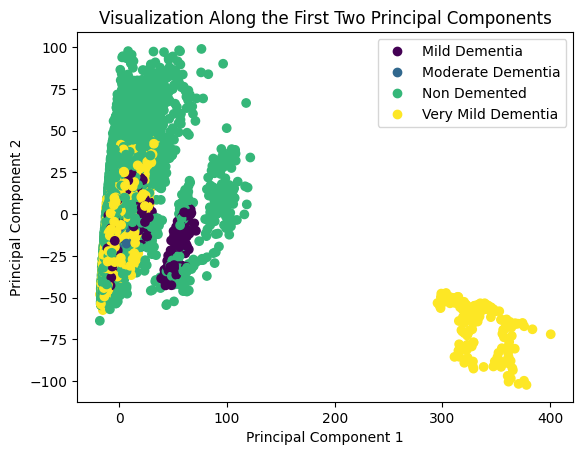

In [8]:
print(X_train.shape)
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.title("Visualization Along the First Two Principal Components")
plt.legend(handles=scatter.legend_elements()[0], labels=['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very Mild Dementia'])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Training  + Cross Validation

### Utilizing Cross Validation to find the best L2 Penalty Parameter

In [10]:
l_model = None
best = 0
C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for C in C_vals:
    model = LogisticRegression(C=C, tol = 0.01, max_iter = 10000, penalty = 'l2', solver = 'lbfgs')
    scores =  cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy')
    results.append(scores.mean())
    if scores.mean() > best:
        best = scores.mean()
        l_model = model
    print("C: {}, Validation Accuracy: {}".format(C, scores.mean()))


C: 0.001, Validation Accuracy: 0.892903559198032
C: 0.01, Validation Accuracy: 0.899111350759833
C: 0.1, Validation Accuracy: 0.8985165206782227
C: 1, Validation Accuracy: 0.8984050448742614
C: 10, Validation Accuracy: 0.8970668654476821
C: 100, Validation Accuracy: 0.8987396449990293
C: 1000, Validation Accuracy: 0.8986281415610066


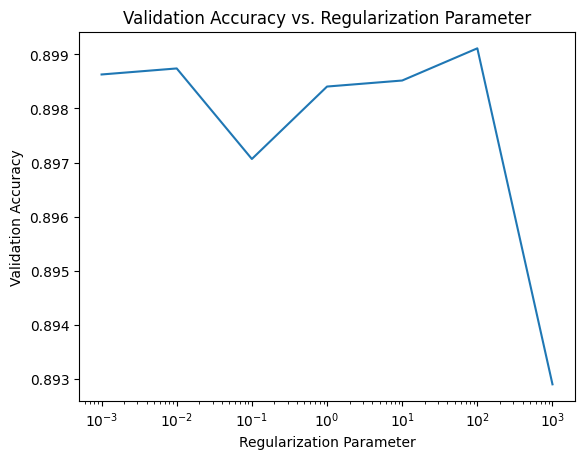

In [11]:
C_vals = np.array(C_vals)
plt.plot(1/C_vals, results)
plt.xscale('log')
plt.title("Validation Accuracy vs. Regularization Parameter")
plt.xlabel("Regularization Parameter")
plt.ylabel("Validation Accuracy")
plt.show()

Note: Per the scikit learn documentation, the parameter C for the Logistic Regression class is equal to the inverse of the L2 regularization parameter $\lambda$ that we are familiar with.

## Testing the Model

In [12]:
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)
l_model.fit(X_train, y_train)
results = l_model.score(X_test, y_test)
print("Test Accuracy: {}".format(results))

Test Accuracy: 0.9044149535952815


## Data Visualization and Metrics

Accuracy: 0.904415
Precision: 0.932763
Recall: 0.934690
F1 Score: 0.933663


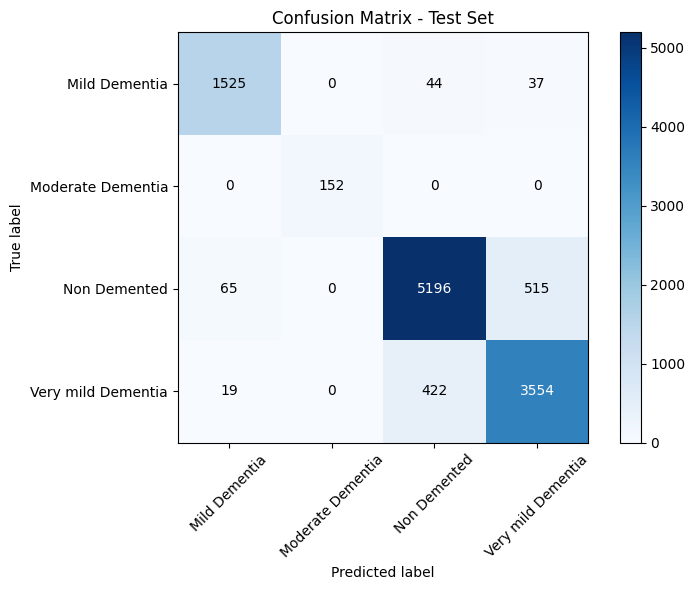

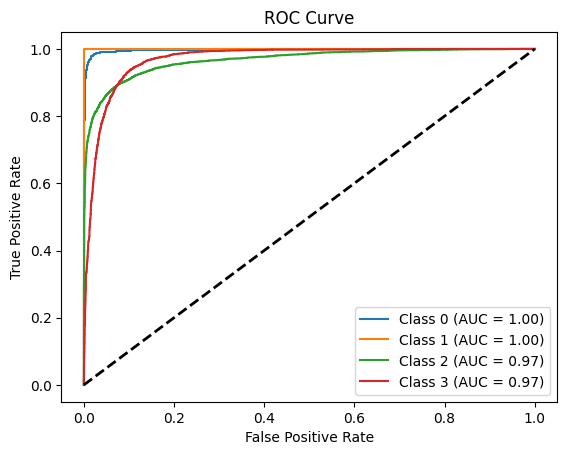

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_pred = l_model.predict(X_test)
y_prob = l_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

conf_matrix_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix_test.max() / 2.
for i in range(conf_matrix_test.shape[0]):
    for j in range(conf_matrix_test.shape[1]):
        plt.text(j, i, format(conf_matrix_test[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix_test[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
